# Result analysis

In [1]:
import os
import sys
import time
import json
import pickle
import shutil
import argparse
import numpy as np
import pandas as pd
import random
import cv2
import scipy.io as sio
from skimage import io

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import scipy.stats as ss
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from DFA.utils.ddfa import ToTensorGjz, NormalizeGjz, str2bool, reconstruct_vertex
from DFA.utils.inference import parse_roi_box_from_landmark, crop_img, predict_68pts, predict_dense
from DFA.utils.estimate_pose import parse_pose
from DFA.utils.render import cget_depths_image

## Demo

### 1. Encoding visualization
Visualize embedded encodings via t-SNE.

In [2]:
prefix = 'freq1'
root = 'test'
video_root = 'x_video/'
frame_root = f'{root}/{prefix}_frames/'
align_root = f'{root}/{prefix}_aligned/'
compo_root = f'{root}/{prefix}_composite/'
score_root = f'{root}/{prefix}_scores/'
# figure_root = f'figures/'
# if not os.path.exists(figure_root):
#     os.mkdir(figure_root)

video_ids = os.listdir(video_root)
video_ids = sorted([x.split('.')[0] for x in video_ids])

In [3]:
# retrieve encodings
encodings = dict.fromkeys(video_ids)
for vid_id in video_ids:
    encoding_list = []
    score_dir = os.path.join(score_root, vid_id)
    with open(os.path.join(score_dir, 'frame_2d_68pts_encodings.pkl'), 'rb') as f:
        frame_2d_dict = pickle.load(f)
    for k, v in frame_2d_dict.items():
        for j, encoding in enumerate(v['encodings']):
            if v['target_idx'] == j:
                encoding_label = 1
            else:
                encoding_label = 0
            encoding_list.append(np.insert(encoding, 0, encoding_label))
    encodings[vid_id] = np.array(encoding_list)
    print(f'Video {vid_id}: {len(encoding_list)} encodings')
encodings_list = []
for k, v in encodings.items():
    if len(v) > 0:
        encodings_list.append(v)

Video 1028790: 155 encodings
Video 1220862: 116 encodings
Video 1239206: 13 encodings
Video 1345564: 64 encodings
Video 211874: 115 encodings
Video 2351268: 120 encodings
Video 2493662: 1 encodings
Video 2541498: 85 encodings
Video 26484: 13 encodings
Video 3104866: 157 encodings
Video 3237487: 64 encodings
Video 3239409: 81 encodings
Video 3255896: 46 encodings
Video 3508904: 51 encodings
Video 3519662: 66 encodings
Video 3594474: 49 encodings
Video 3668040: 79 encodings
Video 3754086: 125 encodings
Video 3768386: 47 encodings
Video 3774670: 47 encodings
Video 3790364: 0 encodings
Video 3809134: 84 encodings
Video 3926450: 48 encodings
Video 3966658: 60 encodings
Video 4078300: 111 encodings
Video 4176302: 90 encodings
Video 4192256: 173 encodings
Video 4255154: 16 encodings
Video 4296512: 19 encodings
Video 476880: 13 encodings
Video 543212: 26 encodings
Video 740764: 101 encodings
Video 98706: 95 encodings


In [4]:
# embed encodings into 2-dim space
X_encoding = np.vstack(encodings_list)
X_embed = TSNE(n_components=2).fit_transform(X_encoding[:, 1:])
num_encoding = [len(v) for v in encodings.values()]
X_index = np.repeat(np.arange(len(video_ids)), num_encoding)

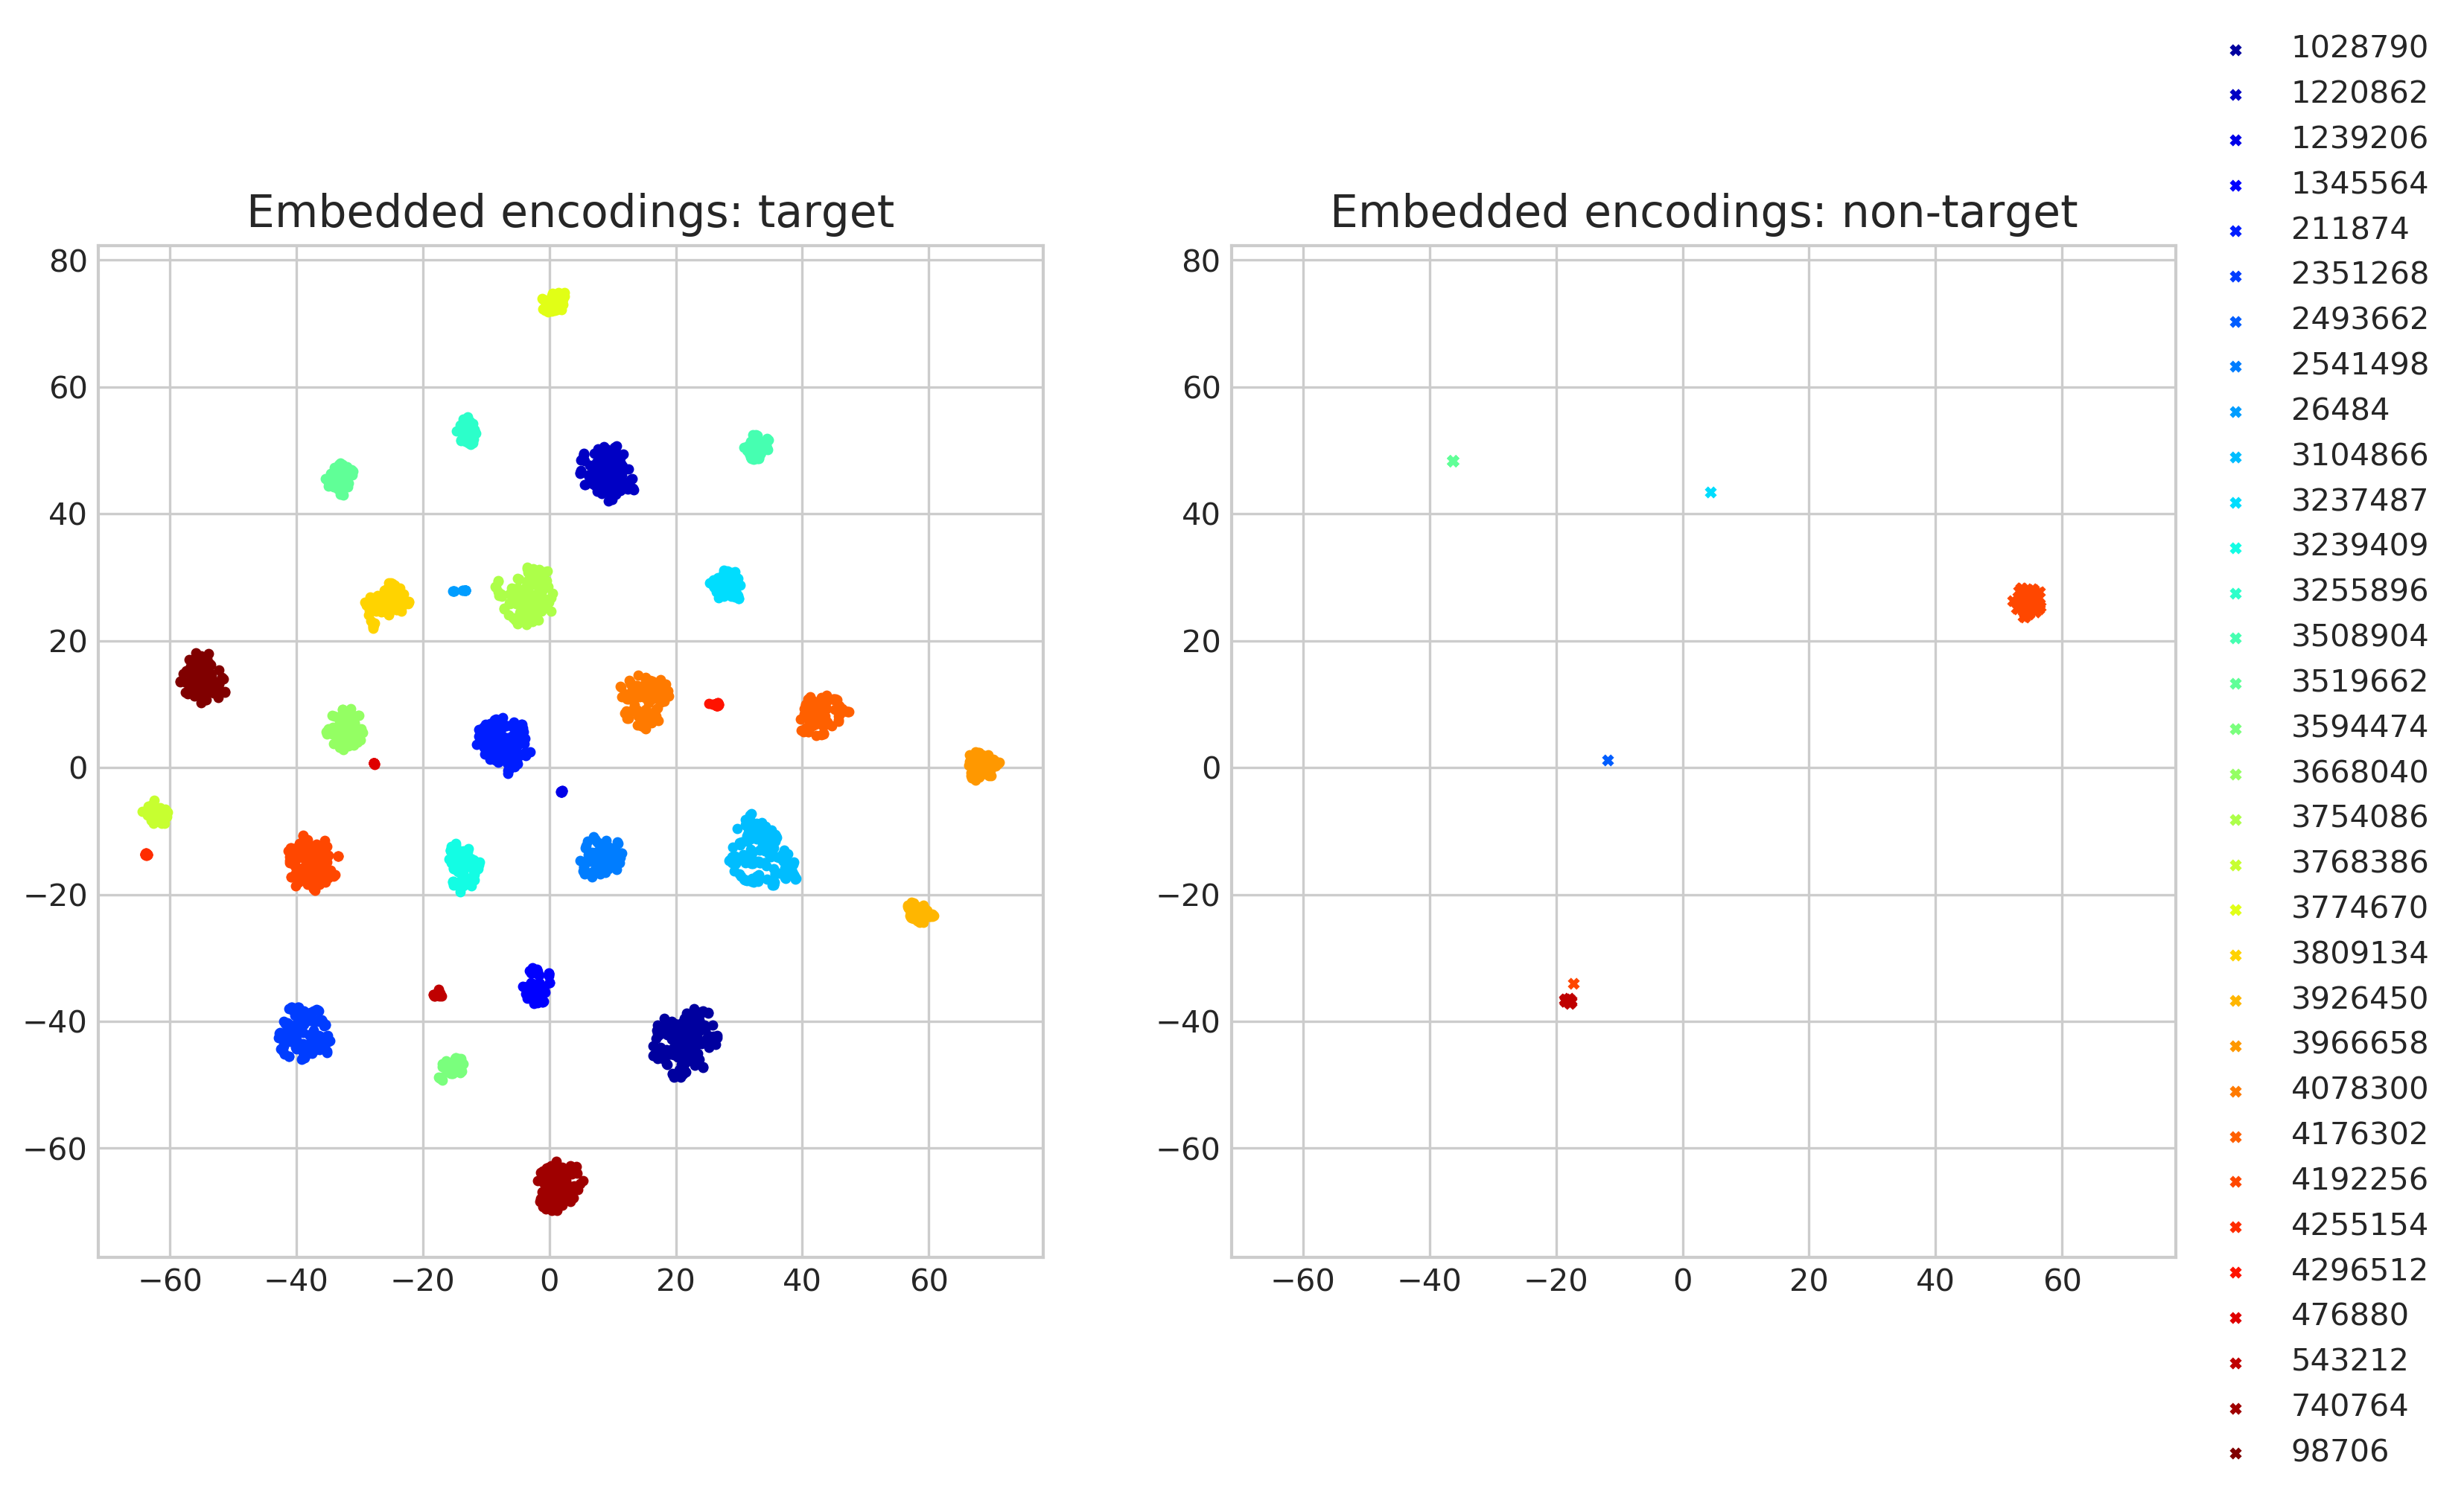

In [5]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
color_seg = np.array_split(cmaplist, len(list(encodings.keys())))
colors = [x[-1] for x in color_seg]
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=300)
for i, (k, v) in enumerate(encodings.items()):
    idx = (X_index == i)
    if sum(idx) == 0:
        continue
    emb = X_embed[idx, :]
    axes[1].scatter(emb[np.where(v[:, 0] == 0), 0], emb[np.where(v[:, 0] == 0), 1], marker='x', s=8, label=video_ids[i],
               color=colors[i].tolist())
    axes[0].scatter(emb[np.where(v[:, 0] == 1), 0], emb[np.where(v[:, 0] == 1), 1], marker='o', s=8, label=video_ids[i],
               color=colors[i].tolist())
    axes[0].set_title('Embedded encodings: target')
    axes[1].set_title('Embedded encodings: non-target')
xlim = (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1]))
ylim = (min(axes[0].get_ylim()[0], axes[1].get_ylim()[0]), max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))
box = axes[1].get_position()
axes[0].set_xlim(xlim); axes[0].set_ylim(ylim); axes[1].set_xlim(xlim); axes[1].set_ylim(ylim)
axes[1].set_position([box.x0, box.y0, box.width, box.height])
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5),
          fancybox=False, shadow=False, ncol=1)
plt.show()

### 2. 3D landmarks

In [6]:
vid_id = '3774670'
k = 'frame720_msec24000'

## prepare
std_size_dfa = 120
frame_dir = os.path.join(frame_root, vid_id)
score_dir = os.path.join(score_root, vid_id)
with open(os.path.join(score_dir, 'frame_2d_68pts_encodings.pkl'), 'rb') as f:
    frame_dict = pickle.load(f)
with open(os.path.join(score_dir, 'target_frame_3d_landmarks.pkl'), 'rb') as f:
    target_3d_dict = pickle.load(f)
dfa_params = pd.read_csv(os.path.join(score_dir, 'target_frame_dfa_params.csv'), sep='\t')
euler_angles = pd.read_csv(os.path.join(score_dir, 'target_frame_euler.csv'), sep='\t')
param = dfa_params.loc[dfa_params['Frame_ID']==k].iloc[:, 1:].to_numpy().flatten()
lms = reconstruct_vertex(param, dense=False)  # (3, 68)
image = cv2.imread(os.path.join(frame_dir, f'{k}.jpg'))
target_rect = frame_dict[k]['locations'][frame_dict[k]['target_idx']]  # rectangle object
# crop image
pts = frame_dict[k]['2d_landmarks'][frame_dict[k]['target_idx']].T
roi_box = parse_roi_box_from_landmark(pts)  # list: [left, top, right, bottom]
img = crop_img(image, roi_box)
# resize to std_size_dfa
img = cv2.resize(img, dsize=(std_size_dfa, std_size_dfa), interpolation=cv2.INTER_LINEAR)

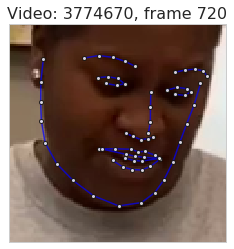

In [7]:
## 3d landmarks on croped image
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img[:, :, ::-1], cmap='gray')

# ax = fig.add_subplot(1, 3, 2)
nums = [0, 17, 22, 27, 31, 36, 42, 48, 60, 68]
for ind in range(len(nums) - 1):
    l, r = nums[ind], nums[ind + 1]
    ax.plot(lms[0, l:r], lms[1, l:r], color='blue', lw=1.5, alpha=0.7)
    ax.plot(lms[0, l:r], lms[1, l:r], marker='o', linestyle='None', markersize=4, color='white',
            markeredgecolor='black', alpha=0.8)
    ax.set_xticks([])
    ax.set_yticks([])
plt.title(f"Video: {vid_id}, frame {k.split('_')[0].replace('frame', '')}", fontsize=16)
plt.show()

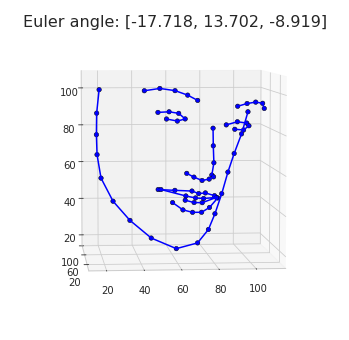

In [8]:
## 3d landmarks in 3d space
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
plt_lms = lms.copy()
plt_lms[1] = img.shape[1] - lms[1]
plt_lms[2] = -lms[2]

# print(lms)
ax.scatter(lms[0], plt_lms[2], plt_lms[1], c="blue", alpha=1.0, edgecolor='black')

for ind in range(len(nums) - 1):
    l, r = nums[ind], nums[ind + 1]
    ax.plot3D(plt_lms[0, l:r], plt_lms[2, l:r], plt_lms[1, l:r], color='blue')

ax.view_init(elev=5., azim=-95)
ax.set_xticks(np.arange(20,120,20))
ax.set_yticks(np.arange(20,120,40))
ax.set_zticks(np.arange(20,120,20))
angles = euler_angles.loc[euler_angles['Frame_ID']==k].iloc[0,1:].values.tolist()
angles = [round(x, 3) for x in angles]
ax.set_title(f"Euler angle: {angles}", fontsize=16)
plt.show()

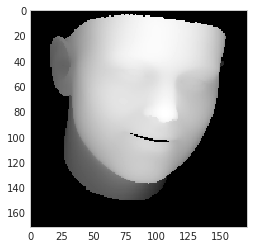

In [9]:
## depth plot: gray scale
img_ori = cv2.flip(image, 1)
tri = sio.loadmat('./DFA/visualize/tri.mat')['tri']
vertices = predict_dense(param, roi_box)
depths_img = cget_depths_image(img_ori, [vertices], tri - 1)  # cython version
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(depths_img[int(roi_box[1])-10:int(roi_box[3])+10, int(roi_box[0])-10:int(roi_box[2])+10],
           cmap='gray')
plt.grid(False)
plt.show()

### 3. Valence-arousal

In [10]:
fer_model = 'emonet'
vid_id = '1239206'
k = 'frame425_msec17000'
emotions_emonet = {0: 'neutral', 1: 'happy', 2: 'sad', 3: 'surprise',
                   4: 'fear', 5: 'disgust', 6: 'anger', 7: 'contempt', 8: 'none'}

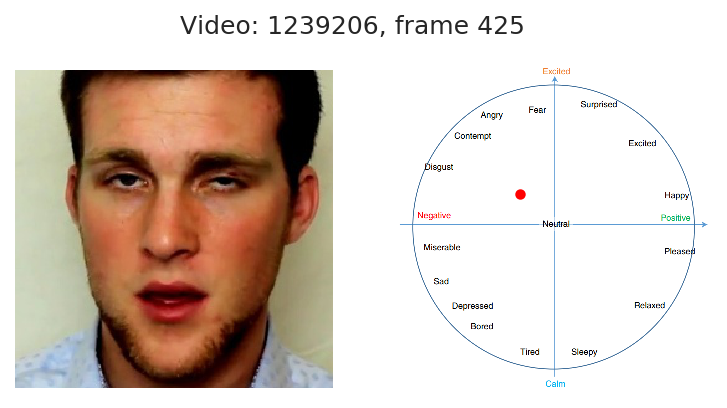

Valence, arousal:
 [-0.215, 0.214]
Emotion probabilities:
 [0.6679516434669495, 6.671957635262515e-07]


In [11]:
align_dir = os.path.join(align_root, vid_id)
score_dir = os.path.join(score_root, vid_id)
with open(os.path.join(score_dir, f'scores_{fer_model}.pkl'), 'rb') as f:
    scores = pickle.load(f)
# plot point on va templete
emo_score = scores['align_emos']
vai_score = scores['align_vai']
va = vai_score.loc[vai_score['Frame_ID']==k].to_numpy().flatten()[1:3]
va_plot = plt.imread('va_template.png')
origin = (va_plot.shape[1] / 2, va_plot.shape[0] / 2)
val = int(origin[0] + va[0] * va_plot.shape[1] / 2)
ars = int(origin[1] - va[1] * va_plot.shape[0] / 2)
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=150)
face = plt.imread(os.path.join(align_dir, f'{k}.jpg'))
axes[0].imshow(face)
axes[0].axis('off')
implot = axes[1].imshow(va_plot)
axes[1].plot(val, ars, marker='o', markersize=4, color='red')
axes[1].axis('off')
fig.suptitle(f"Video: {vid_id}, frame {k.split('_')[0].replace('frame', '')}", fontsize=12)
plt.show()
print('Valence, arousal:\n', f'{[round(va[0],3), round(va[1],3)]}')
print('Emotion probabilities:\n', emo_score.loc[emo_score['Frame_ID']==k].to_numpy().flatten()[1:3].tolist())

## Statistics

In [12]:
prefix = 'all'
root = 'test'
video_root = 'x_video/'
frame_root = f'{root}/{prefix}_frames/'
align_root = f'{root}/{prefix}_aligned/'
compo_root = f'{root}/{prefix}_composite/'
score_root = f'{root}/{prefix}_scores/'

video_ids = os.listdir(video_root)
video_ids = sorted([x.split('.')[0] for x in video_ids])

### 1. Euler angle

In [13]:
# exclude some videos with low quality
exclude = ['476880', '543212', '2493662', '3790364', '4255154', '4296512']
plt_ids = [x for x in video_ids if x not in exclude]
alphas, betas, gammas = dict.fromkeys(plt_ids), dict.fromkeys(plt_ids), dict.fromkeys(plt_ids)
for vid_id in plt_ids:
    score_dir = os.path.join(score_root, vid_id)
    angles = pd.read_csv(os.path.join(score_dir, 'target_frame_euler.csv'), sep='\t')
    alpha = angles['alpha'].values
    beta = angles['beta'].values
    gamma = angles['gamma'].values
    alphas[vid_id] = alpha
    betas[vid_id] = beta
    gammas[vid_id] = gamma

In [14]:
alphas_mean, alphas_min, alphas_max = np.array([np.mean(v) for v in alphas.values()]), np.array([np.min(v) for v in alphas.values()]), np.array([np.max(v) for v in alphas.values()])
betas_mean, betas_min, betas_max = np.array([np.mean(v) for v in betas.values()]), np.array([np.min(v) for v in betas.values()]), np.array([np.max(v) for v in betas.values()])
gammas_mean, gammas_min, gammas_max = np.array([np.mean(v) for v in gammas.values()]), np.array([np.min(v) for v in gammas.values()]), np.array([np.max(v) for v in gammas.values()])

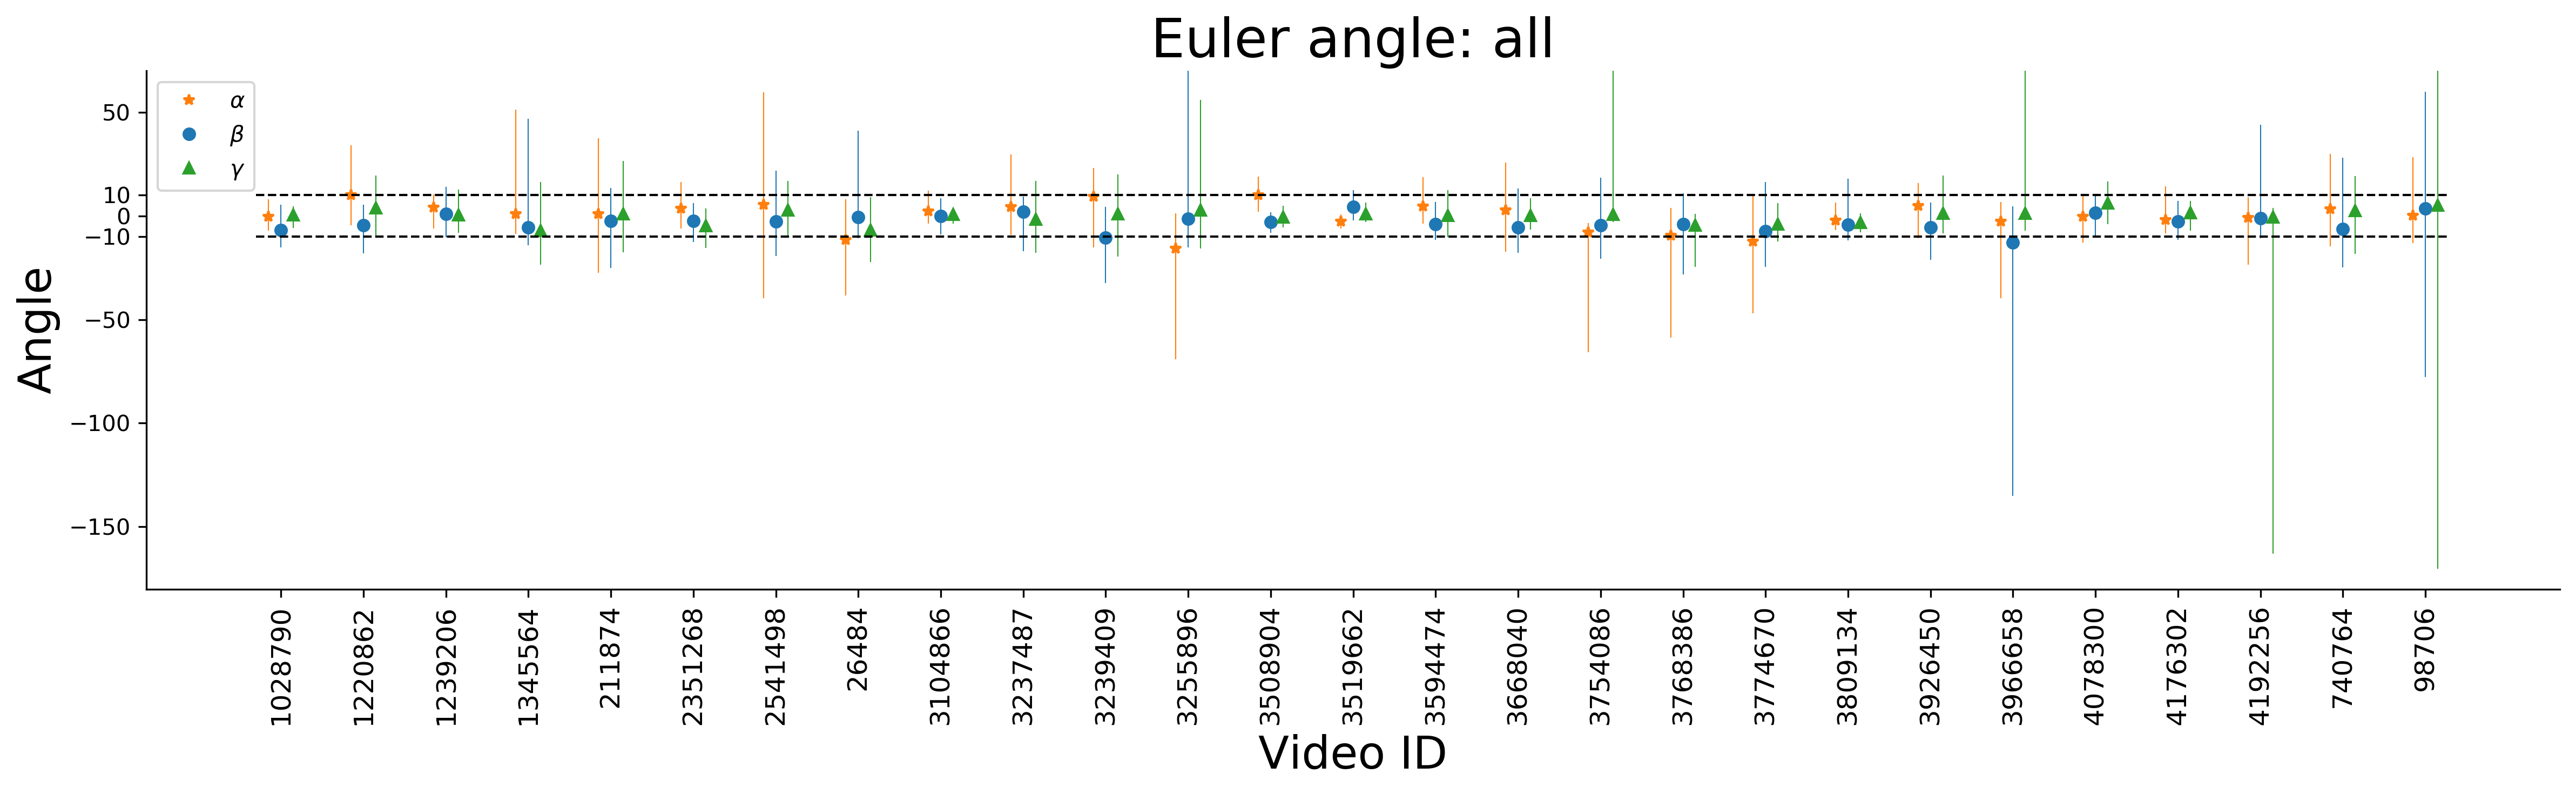

In [15]:
## Euler angle without filtering images with low brightness
width = 0.3
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 5), dpi=300)
angle_names = [r'$\alpha$', r'$\beta$', r'$\gamma$']
x = np.arange(len(alphas_mean))
ax.plot(x-width*.5, alphas_mean, marker='*', ls='', ms=5, c='C1', label=r'$\alpha$')
ax.plot(x, betas_mean, marker='o', ls='', ms=5, c='C0', label=r'$\beta$')
ax.plot(x+width*.5, gammas_mean, marker='^', ls='', ms=5, c='C2', label=r'$\gamma$')
for i in range(len(alphas_mean)):
    ax.plot([x[i]-width*.5, x[i]-width*.5], [alphas_mean[i], alphas_max[i]], lw=0.5, c='C1')
    ax.plot([x[i]-width*.5, x[i]-width*.5], [alphas_min[i], alphas_mean[i]], lw=0.5, c='C1')
    ax.plot([x[i], x[i]], [betas_mean[i], betas_max[i]], lw=0.5, c='C0')
    ax.plot([x[i], x[i]], [betas_min[i], betas_mean[i]], lw=0.5, c='C0')
    ax.plot([x[i]+width*.5, x[i]+width*.5], [gammas_mean[i], gammas_max[i]], lw=0.5, c='C2')
    ax.plot([x[i]+width*.5, x[i]+width*.5], [gammas_min[i], gammas_mean[i]], lw=0.5, c='C2')
ax.plot([-width, len(alphas_mean)-1+width], [-10, -10], ls='--', lw=1, c='black')
ax.plot([-width, len(alphas_mean)-1+width], [10, 10], ls='--', lw=1, c='black')
ax.legend(loc=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, len(alphas_mean)))
ax.set_xticklabels(alphas.keys(), rotation=90, fontsize=12)
ax.set_xlabel('Video ID', fontsize=20)
ax.set_ylabel('Angle', fontsize=20)
ax.set_yticks(list(ax.get_yticks()) + [-10, 10])
ax.set_title(f'Euler angle: all', fontsize=24)
ax.set_ylim(-180, 70)
plt.tight_layout()
plt.show()

In [16]:
# calculate brightness
if os.path.exists(f'{root}/{prefix}_brightness.pkl'):
    with open(f'{root}/{prefix}_brightness.pkl', 'rb') as f:
        brightness = pickle.load(f)
else:
    brightness = dict.fromkeys(plt_ids)
    for vid_id in plt_ids:
        align_dir = os.path.join(align_root, vid_id)
        align_files = os.listdir(align_dir)
        align_files = [x for x in align_files if '.jpg' in x]
        align_files = sorted(align_files, key=lambda x: int(x.split('_')[0].replace('frame', '')))
        align_ids = [x.split('.')[0] for x in align_files]
        bri = []
        for i, align_file in enumerate(align_files):
            img = cv2.imread(os.path.join(align_dir, align_file))
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            bri.append(np.max(hsv[:,:,2]))
        brightness[vid_id] = bri
        print(f'Calculated brightness: video {vid_id}')
    with open(f'{root}/{prefix}_brightness.pkl', 'wb') as f:
        pickle.dump(brightness, f)

Calculated brightness: video 1028790
Calculated brightness: video 1220862
Calculated brightness: video 1239206
Calculated brightness: video 1345564
Calculated brightness: video 211874
Calculated brightness: video 2351268
Calculated brightness: video 2541498
Calculated brightness: video 26484
Calculated brightness: video 3104866
Calculated brightness: video 3237487
Calculated brightness: video 3239409
Calculated brightness: video 3255896
Calculated brightness: video 3508904
Calculated brightness: video 3519662
Calculated brightness: video 3594474
Calculated brightness: video 3668040
Calculated brightness: video 3754086
Calculated brightness: video 3768386
Calculated brightness: video 3774670
Calculated brightness: video 3809134
Calculated brightness: video 3926450
Calculated brightness: video 3966658
Calculated brightness: video 4078300
Calculated brightness: video 4176302
Calculated brightness: video 4192256
Calculated brightness: video 740764
Calculated brightness: video 98706


In [17]:
# exclude frames with low brightness
bri_ids = [np.where(np.array(v)>50)[0].tolist() for k, v in brightness.items()]
alphas_mean, alphas_min, alphas_max = np.array([np.mean(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(alphas.items())]), np.array([np.min(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(alphas.items())]), np.array([np.max(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(alphas.items())])
betas_mean, betas_min, betas_max = np.array([np.mean(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(betas.items())]), np.array([np.min(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(betas.items())]), np.array([np.max(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(betas.items())])
gammas_mean, gammas_min, gammas_max = np.array([np.mean(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(gammas.items())]), np.array([np.min(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(gammas.items())]), np.array([np.max(np.array(v)[bri_ids[i]]) for i, (_, v) in enumerate(gammas.items())])

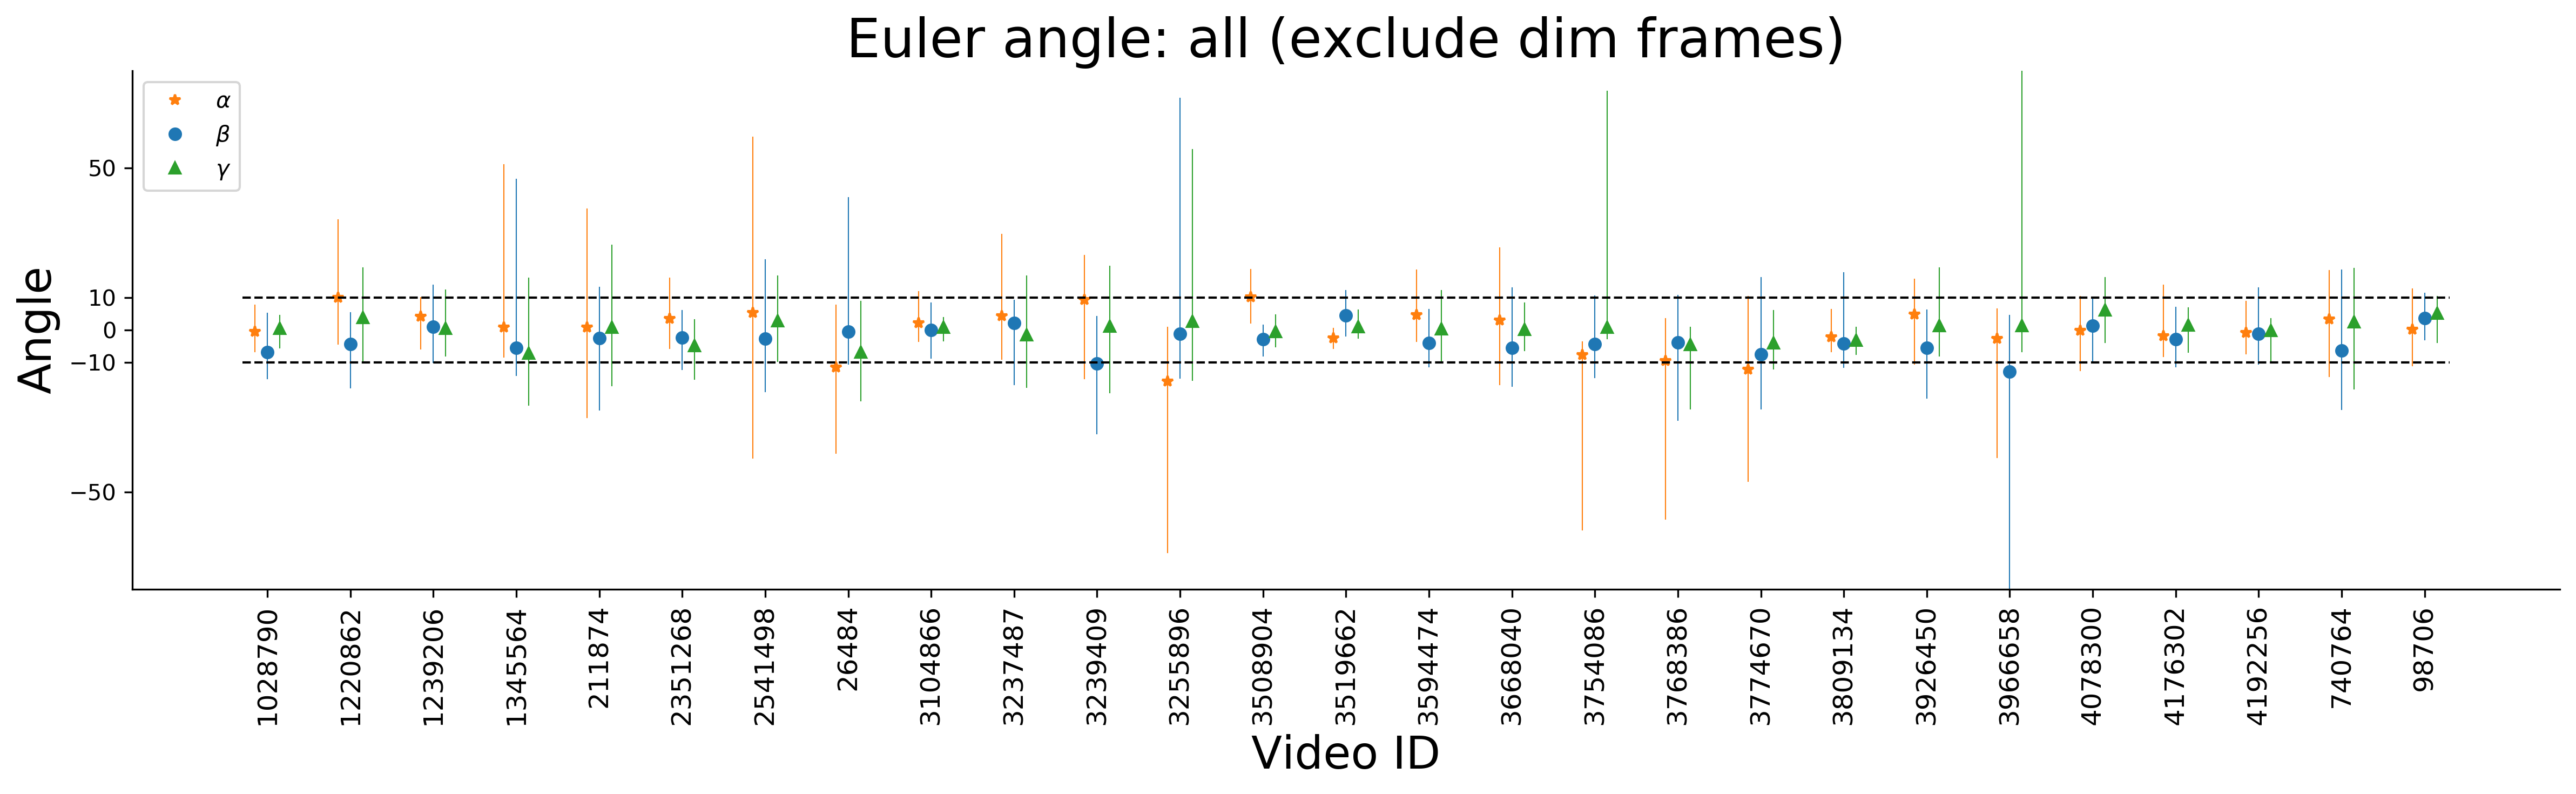

In [18]:
## Euler angle with filtering images with low brightness
## 'frame5806_msec193533' of '3966658' did not correctly detect the face
width = 0.3
fig, ax = plt.subplots(figsize=(16, 5), dpi=300)
angle_names = [r'$\alpha$', r'$\beta$', r'$\gamma$']
x = np.arange(len(alphas_mean))
ax.plot(x-width*.5, alphas_mean, marker='*', ls='', ms=5, c='C1', label=r'$\alpha$')
ax.plot(x, betas_mean, marker='o', ls='', ms=5, c='C0', label=r'$\beta$')
ax.plot(x+width*.5, gammas_mean, marker='^', ls='', ms=5, c='C2', label=r'$\gamma$')
for i in range(len(alphas_mean)):
    ax.plot([x[i]-width*.5, x[i]-width*.5], [alphas_mean[i], alphas_max[i]], lw=0.5, c='C1')
    ax.plot([x[i]-width*.5, x[i]-width*.5], [alphas_min[i], alphas_mean[i]], lw=0.5, c='C1')
    ax.plot([x[i], x[i]], [betas_mean[i], betas_max[i]], lw=0.5, c='C0')
    ax.plot([x[i], x[i]], [betas_min[i], betas_mean[i]], lw=0.5, c='C0')
    ax.plot([x[i]+width*.5, x[i]+width*.5], [gammas_mean[i], gammas_max[i]], lw=0.5, c='C2')
    ax.plot([x[i]+width*.5, x[i]+width*.5], [gammas_min[i], gammas_mean[i]], lw=0.5, c='C2')
ax.plot([-width, len(alphas_mean)-1+width], [-10, -10], ls='--', lw=1, c='black')
ax.plot([-width, len(alphas_mean)-1+width], [10, 10], ls='--', lw=1, c='black')
ax.legend(loc=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, len(alphas_mean)))
ax.set_xticklabels(alphas.keys(), rotation=90, fontsize=12)
ax.set_xlabel('Video ID', fontsize=20)
ax.set_ylabel('Angle', fontsize=20)
ax.set_yticks(list(ax.get_yticks()) + [-10, 10])
ax.set_title(f'Euler angle: all (exclude dim frames)', fontsize=24)
ax.set_ylim(-80, 80)
plt.tight_layout()
plt.show()

### 2. Valence, arousal, intensity

In [19]:
fer_model = 'emonet'
valences, arousals, intensities = dict.fromkeys(plt_ids), dict.fromkeys(plt_ids), dict.fromkeys(plt_ids)
for vid_id in plt_ids:
    score_dir = os.path.join(score_root, vid_id)
    with open(os.path.join(score_dir, f'scores_{fer_model}.pkl'), 'rb') as f:
        scores = pickle.load(f)
    align_vai = scores['align_vai']
    valences[vid_id] = align_vai['Valence']
    arousals[vid_id] = align_vai['Arousal']
    intensities[vid_id] = align_vai['Intensity']

In [20]:
scores['align_vai'].head()

,Frame_ID,Valence,Arousal,Intensity
0,frame4_msec138,-0.171334,0.300137,0.345597
1,frame5_msec172,-0.141979,0.290750,0.323564
2,frame6_msec207,-0.234634,0.089901,0.251268
3,frame7_msec241,-0.192675,0.200879,0.278345
4,frame8_msec276,-0.221200,0.226684,0.316726


In [21]:
vals_mean, vals_min, vals_max = tuple(zip(*[[np.mean(v), np.min(v), np.max(v)] for v in valences.values()]))
ars_mean, ars_min, ars_max = tuple(zip(*[[np.mean(v), np.min(v), np.max(v)] for v in arousals.values()]))
intens_mean, intens_min, intens_max = tuple(zip(*[[np.mean(v), np.min(v), np.max(v)] for v in intensities.values()]))

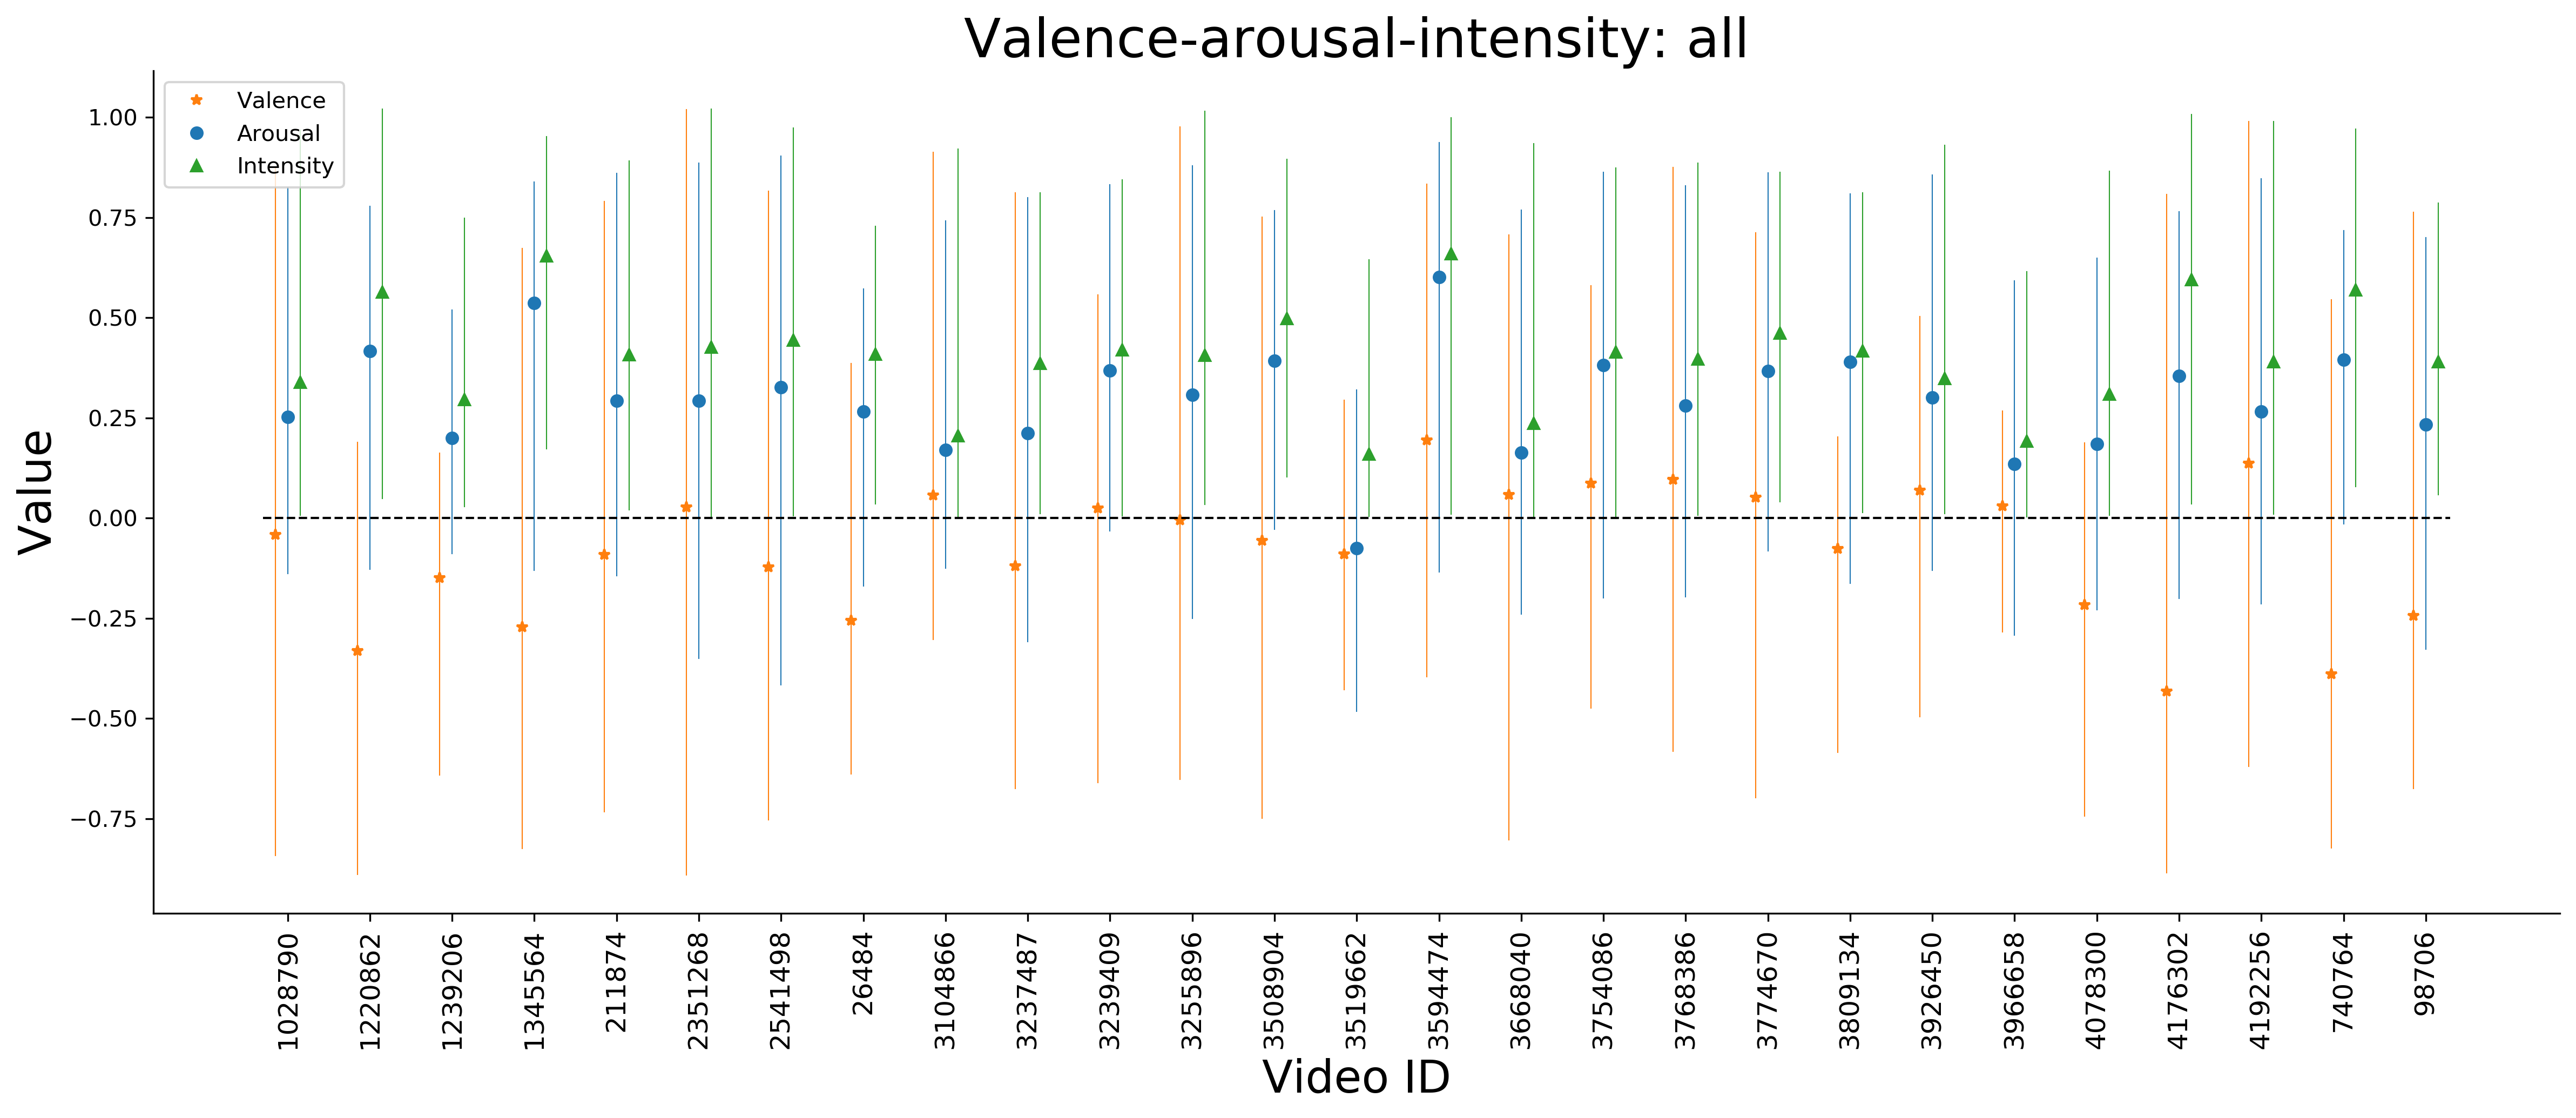

In [22]:
width = 0.3
plt.style.use('default')
fig, ax = plt.subplots(figsize=(16, 7), dpi=300)
names = ['Valence', 'Arousal', 'Intensity']
x = np.arange(len(vals_mean))
ax.plot(x-width*.5, vals_mean, marker='*', ls='', ms=5, c='C1', label='Valence')
ax.plot(x, ars_mean, marker='o', ls='', ms=5, c='C0', label='Arousal')
ax.plot(x+width*.5, intens_mean, marker='^', ls='', ms=5, c='C2', label='Intensity')
for i in range(len(alphas_mean)):
    ax.plot([x[i]-width*.5, x[i]-width*.5], [vals_mean[i], vals_max[i]], lw=0.5, c='C1')
    ax.plot([x[i]-width*.5, x[i]-width*.5], [vals_min[i], vals_mean[i]], lw=0.5, c='C1')
    ax.plot([x[i], x[i]], [ars_mean[i], ars_max[i]], lw=0.5, c='C0')
    ax.plot([x[i], x[i]], [ars_min[i], ars_mean[i]], lw=0.5, c='C0')
    ax.plot([x[i]+width*.5, x[i]+width*.5], [intens_mean[i], intens_max[i]], lw=0.5, c='C2')
    ax.plot([x[i]+width*.5, x[i]+width*.5], [intens_min[i], intens_mean[i]], lw=0.5, c='C2')
ax.plot([-width, len(alphas_mean)-1+width], [0, 0], ls='--', lw=1, c='black')
ax.legend(loc=2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(np.arange(0, len(vals_mean)))
ax.set_xticklabels(valences.keys(), rotation=90, fontsize=12)
ax.set_xlabel('Video ID', fontsize=20)
ax.set_ylabel('Value', fontsize=20)
ax.set_title(f'Valence-arousal-intensity: all', fontsize=24)
plt.tight_layout()
plt.show()

### 3. FAsy by emotion probabilities vs intensities (EmoNet)

In [23]:
scores.keys()

dict_keys(['align_emos', 'left_emos', 'right_emos', 'FAsy_emos', 'align_vai', 'left_vai', 'right_vai', 'FAsy_vai'])

In [24]:
fer_model = 'emonet'
align_vai, FAsy_emos, FAsy_vai = dict.fromkeys(plt_ids), dict.fromkeys(plt_ids), dict.fromkeys(plt_ids)
for vid_id in plt_ids:
    score_dir = os.path.join(score_root, vid_id)
    with open(os.path.join(score_dir, f'scores_{fer_model}.pkl'), 'rb') as f:
        scores = pickle.load(f)
    align_vai[vid_id] = scores['align_vai'].iloc[:,1:].values
    FAsy_emos[vid_id] = scores['FAsy_emos'].iloc[:,1:].values
    FAsy_vai[vid_id] = scores['FAsy_vai'].iloc[:,1:].values

In [25]:
# average FAsy_euc calculated by difference in emotions or valence-arousal of each video
emos_euc_avg = [np.mean((np.sum(v**2, 1)/8)**0.5) for v in FAsy_emos.values()]
vai_euc_avg = [np.mean((np.sum(v[:,:2]**2, 1)/2)**0.5) for v in FAsy_vai.values()]

In [26]:
# correlation between FAsy_emo and FAsy_vai of each video
emos_euc = [(np.sum(v**2, 1)/8)**0.5 for v in FAsy_emos.values()]
vai_euc = [(np.sum(v[:,:2]**2, 1))**0.5 for v in FAsy_vai.values()]
corr_emos_vai = [ss.pearsonr(emos_euc[i], vai_euc[i])[0] for i in range(len(emos_euc))]

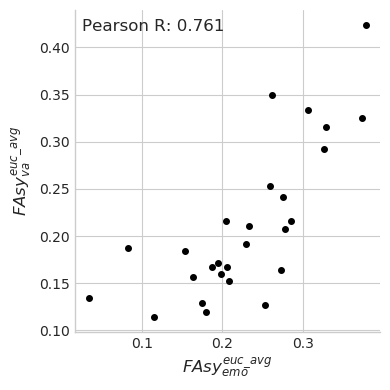

In [27]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
ax.plot(emos_euc_avg, vai_euc_avg, marker='o', ls='', ms=4, c='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(ax.get_xlim()[0]*1.5, ax.get_ylim()[1]*0.95, f'Pearson R: {round(ss.pearsonr(emos_euc_avg, vai_euc_avg)[0], 3)}', fontsize=12)
ax.set_xlabel(r'$FAsy_{emo}^{euc\_avg}$', fontsize=12)
ax.set_ylabel(r'$FAsy_{va}^{euc\_avg}$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()

### 4. Valence-arousal-intensity time series

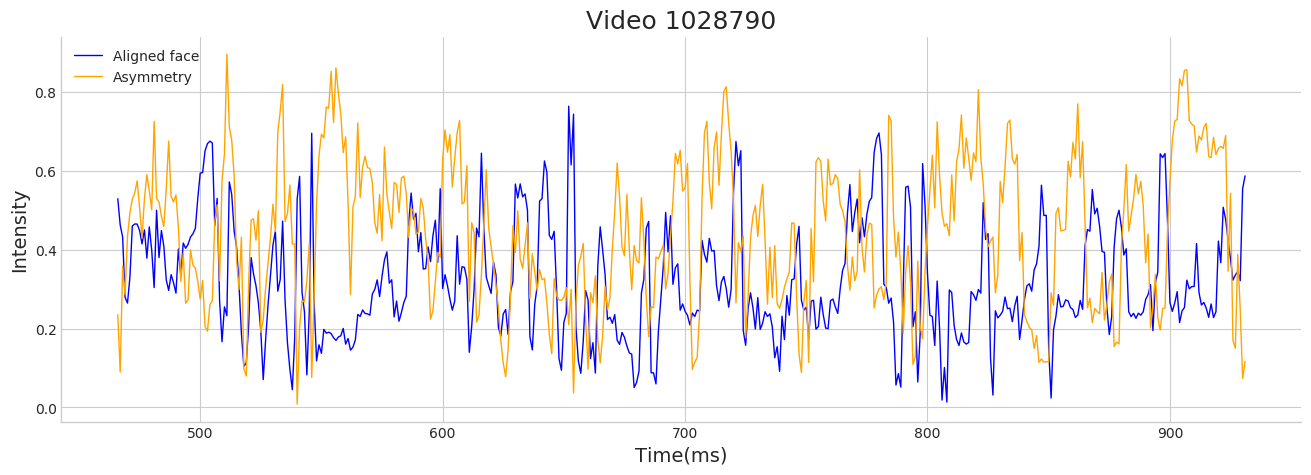

In [28]:
vid_id = '1028790'
fig, ax = plt.subplots(figsize=(16, 5))
t1, t2, length = 0.1, 0.2, align_vai[vid_id].shape[0]
x = np.arange(length)
y1 = align_vai[vid_id][:,2] # intensity
y2 = np.sqrt((FAsy_vai[vid_id][:,0]**2 + FAsy_vai[vid_id][:,1]**2)/2)
ax.plot(x[int(t1*length):int(t2*length)], y1[int(t1*length):int(t2*length)], color='blue', lw=1, label='Aligned face')
ax.plot(x[int(t1*length):int(t2*length)], y2[int(t1*length):int(t2*length)], color='orange', lw=1, label='Asymmetry')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Time(ms)', fontsize=14)
ax.set_ylabel('Intensity', fontsize=14)
ax.set_title(f'Video {vid_id}', fontsize=18)
ax.legend(loc='upper left')
plt.show()

### 5. Confusion matrix: EmoNet vs Ferplus

In [29]:
def heatmap_confusion_emo_models(emonet_cls, ferplus_cls, title='', save=None):
    # confusion matrix
    conf_mat = confusion_matrix(emonet_cls, ferplus_cls, labels=list(emotions_emonet.values()))
    df_cm = pd.DataFrame(conf_mat, index=list(emotions_emonet.values()), columns=list(emotions_emonet.values()))
    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(10, 8), dpi=150)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g', linewidth=2, linecolor='white')
    ax.set_yticklabels(list(emotions_emonet.values()), rotation=0, fontsize=10)
    ax.set_xticklabels(list(emotions_emonet.values()), rotation=0, fontsize=10)
    ax.set_title(title, fontsize=14)
    # if save is not none:
    #     plt.savefig(save)
    plt.close()

In [30]:
emotions_emonet = {0: 'neutral', 1: 'happy', 2: 'sad', 3: 'surprise',
                       4: 'fear', 5: 'disgust', 6: 'anger', 7: 'contempt'}
emotions_ferplus = {0: 'neutral', 1: 'happy', 2: 'surprise', 3: 'sad',
                    4: 'anger', 5: 'disgust', 6: 'fear', 7: 'contempt'}
for vid_id in plt_ids:
    emonet_emos, ferplus_emos = {}, {}
    score_dir = os.path.join(score_root, vid_id)
    with open(os.path.join(score_dir, f'scores_emonet.pkl'), 'rb') as f:
        scores = pickle.load(f)
    emonet_emos = scores['align_emos'].iloc[:,1:].values
    emonet_idx = np.argmax(emonet_emos, axis=1)
    emonet_cls = [emotions_emonet[i] for i in emonet_idx]
    with open(os.path.join(score_dir, f'scores_ferplus.pkl'), 'rb') as f:
        scores = pickle.load(f)
    ferplus_emos = scores['align_emos'].iloc[:,1:].values
    ferplus_idx = np.argmax(ferplus_emos, axis=1)
    ferplus_cls = [emotions_ferplus[i] for i in ferplus_idx]
    # confusion heatmap
    heatmap_confusion_emo_models(emonet_cls, ferplus_cls, f'{vid_id}', None)

### 6a. Correlation between FAsy and Euler angles (EmoNet)

In [31]:
corr_FAsy_alpha = list(zip(*[ss.pearsonr((np.sum(FAsy_emos[k]**2, 1)/8)**0.5, np.abs(alphas[k])) for k in plt_ids]))
corr_FAsy_beta = list(zip(*[ss.pearsonr((np.sum(FAsy_emos[k]**2, 1)/8)**0.5, np.abs(betas[k])) for k in plt_ids]))
corr_FAsy_gamma = list(zip(*[ss.pearsonr((np.sum(FAsy_emos[k]**2, 1)/8)**0.5, np.abs(gammas[k])) for k in plt_ids]))
corr_FAsy_euler_dict = {'Video': plt_ids, 'corr_FAsy_alpha': corr_FAsy_alpha[0],
                        'corr_FAsy_beta': corr_FAsy_beta[0], 'corr_FAsy_gamma': corr_FAsy_gamma[0]}
corr_FAsy_euler_df = pd.DataFrame.from_dict(corr_FAsy_euler_dict)

In [32]:
# EmoNet FAsy_emo
corr_FAsy_euler_df

,Video,corr_FAsy_alpha,corr_FAsy_beta,corr_FAsy_gamma
0,1028790,0.059285,-0.030966,-0.042850
1,1220862,0.059590,-0.102344,0.004568
2,1239206,-0.045603,0.186367,-0.047204
3,1345564,-0.094340,-0.085258,-0.015134
4,211874,0.155297,-0.013240,0.042724
5,2351268,-0.077014,0.073245,0.015959
6,2541498,0.086778,0.036634,0.115343
7,26484,-0.086982,-0.058889,-0.029219
8,3104866,0.118862,0.280264,-0.011666
9,3237487,0.128977,0.017377,-0.187029


In [33]:
corr_FAsy_alpha = list(zip(*[ss.pearsonr((np.sum(FAsy_vai[k][:,:2]**2, 1))**0.5, np.abs(alphas[k])) for k in plt_ids]))
corr_FAsy_beta = list(zip(*[ss.pearsonr((np.sum(FAsy_vai[k][:,:2]**2, 1))**0.5, np.abs(betas[k])) for k in plt_ids]))
corr_FAsy_gamma = list(zip(*[ss.pearsonr((np.sum(FAsy_vai[k][:,:2]**2, 1))**0.5, np.abs(gammas[k])) for k in plt_ids]))
corr_FAsy_euler_dict = {'Video': plt_ids, 'corr_FAsy_alpha': corr_FAsy_alpha[0],
                        'corr_FAsy_beta': corr_FAsy_beta[0], 'corr_FAsy_gamma': corr_FAsy_gamma[0]}
corr_FAsy_euler_df = pd.DataFrame.from_dict(corr_FAsy_euler_dict)

In [34]:
# EmoNet FAsy_va
corr_FAsy_euler_df

,Video,corr_FAsy_alpha,corr_FAsy_beta,corr_FAsy_gamma
0,1028790,0.047563,-0.018124,0.005780
1,1220862,0.029626,0.123188,0.025762
2,1239206,0.365095,-0.035477,0.297222
3,1345564,0.165266,0.000733,0.060663
4,211874,0.354315,0.025573,0.125665
5,2351268,-0.118405,0.081477,0.022494
6,2541498,-0.061868,0.017549,0.100944
7,26484,-0.003297,-0.184676,-0.014604
8,3104866,0.237922,0.391859,-0.000656
9,3237487,0.112926,0.048435,-0.126571


### 6b. Correlation between FAsy and Euler angles (Ferplus)

In [35]:
fer_model = 'ferplus'
FAsy_emos = dict.fromkeys(plt_ids)
for vid_id in plt_ids:
    score_dir = os.path.join(score_root, vid_id)
    with open(os.path.join(score_dir, f'scores_{fer_model}.pkl'), 'rb') as f:
        scores = pickle.load(f)
    FAsy_emos[vid_id] = scores['FAsy_emos'].iloc[:,1:].values

In [36]:
corr_FAsy_alpha = list(zip(*[ss.pearsonr((np.sum(FAsy_emos[k]**2, 1)/8)**0.5, np.abs(alphas[k])) for k in plt_ids]))
corr_FAsy_beta = list(zip(*[ss.pearsonr((np.sum(FAsy_emos[k]**2, 1)/8)**0.5, np.abs(betas[k])) for k in plt_ids]))
corr_FAsy_gamma = list(zip(*[ss.pearsonr((np.sum(FAsy_emos[k]**2, 1)/8)**0.5, np.abs(gammas[k])) for k in plt_ids]))

In [37]:
corr_FAsy_euler_dict = {'Video': plt_ids, 'corr_FAsy_alpha': corr_FAsy_alpha[0],
                        'corr_FAsy_beta': corr_FAsy_beta[0], 'corr_FAsy_gamma': corr_FAsy_gamma[0]}
corr_FAsy_euler_df = pd.DataFrame.from_dict(corr_FAsy_euler_dict)

In [38]:
corr_FAsy_euler_df

,Video,corr_FAsy_alpha,corr_FAsy_beta,corr_FAsy_gamma
0,1028790,0.012407,0.065034,-0.049943
1,1220862,0.282523,0.077104,0.158748
2,1239206,0.206400,-0.055377,0.258513
3,1345564,0.320058,0.096816,0.028314
4,211874,0.220683,0.110885,0.137960
5,2351268,0.164026,0.178893,0.123582
6,2541498,0.327502,0.114287,0.277202
7,26484,0.111313,0.014292,0.231844
8,3104866,-0.037136,0.037376,-0.024740
9,3237487,0.168672,-0.076670,-0.090531


### 7. Correlation between EmoNet FAsy and Ferplus FAsy

In [39]:
FAsy_emonet, FAsy_ferplus = dict.fromkeys(plt_ids), dict.fromkeys(plt_ids)
for vid_id in plt_ids:
    score_dir = os.path.join(score_root, vid_id)
    with open(os.path.join(score_dir, f'scores_emonet.pkl'), 'rb') as f:
        scores_emonet = pickle.load(f)
    with open(os.path.join(score_dir, f'scores_ferplus.pkl'), 'rb') as f:
        scores_ferplus = pickle.load(f)
    FAsy_emonet[vid_id] = scores_emonet['FAsy_emos'].iloc[:,1:].values
    FAsy_ferplus[vid_id] = scores_ferplus['FAsy_emos'].iloc[:,1:].values

In [40]:
emonet_euc_avg = [np.mean((np.sum(v**2, 1)/8)**0.5) for v in FAsy_emonet.values()]
ferplus_euc_avg = [np.mean((np.sum(v**2, 1)/8)**0.5) for v in FAsy_ferplus.values()]

In [41]:
emonet_euc = [(np.sum(v**2, 1)/8)**0.5 for v in FAsy_emonet.values()]
ferplus_euc = [(np.sum(v[:,:2]**2, 1)/8)**0.5 for v in FAsy_ferplus.values()]
corr_emonet_ferplus = [ss.pearsonr(emonet_euc[i], ferplus_euc[i])[0] for i in range(len(emonet_euc))]

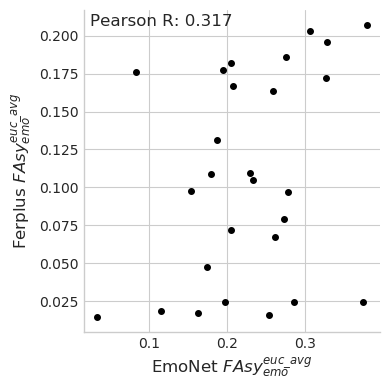

In [42]:
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(4, 4), dpi=100)
ax.plot(emonet_euc_avg, ferplus_euc_avg, marker='o', ls='', ms=4, c='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.text(ax.get_xlim()[0]*1.5, ax.get_ylim()[1]*0.95, f'Pearson R: {round(ss.pearsonr(emonet_euc_avg, ferplus_euc_avg)[0], 3)}', fontsize=12)
ax.set_xlabel(r'EmoNet $FAsy_{emo}^{euc\_avg}$', fontsize=12)
ax.set_ylabel(r'Ferplus $FAsy_{emo}^{euc\_avg}$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout()
plt.show()